In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns

import nltk
from nltk.tokenize import (sent_tokenize, TreebankWordTokenizer, WhitespaceTokenizer)
from nltk.stem.porter import PorterStemmer
from nltk.util import ngrams
from nltk.corpus import stopwords

from collections import Counter
from operator import itemgetter

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import re

# from sqlalchemy import create_engine

from sklearn.naive_bayes import GaussianNB, BernoulliNB,MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import (accuracy_score, classification_report,confusion_matrix, precision_score, 
                             recall_score, f1_score, roc_curve, roc_auc_score, average_precision_score, 
                             precision_recall_curve, auc)

from sklearn.utils import resample
from sklearn.cross_validation import train_test_split 
from sklearn.model_selection import KFold  
from sklearn.preprocessing import StandardScaler 

from sklearn.base import TransformerMixin

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

from sklearn.utils import shuffle

from xgboost import XGBClassifier

import datetime
import warnings
import os

warnings.filterwarnings("ignore")

In [23]:
# helper functions
def sentence_tokenizer(text):
    sentences = sent_tokenize(text)
    return sentences

def whitespace_tokenizer(sentences):
    listy = []
    tokenizer = WhitespaceTokenizer()
    for i in list(range(0,len(sentences))):
        tokenized = tokenizer.tokenize(sentences[i])
        listy.append(tokenized)
    return listy

def polarity(sentences):
    listy = []
    for i in list(range(0,len(sentences))):
        pol = TextBlob(sentences[i]).polarity
        listy.append(pol)
    return np.min(listy), np.max(listy), np.mean(listy),listy

def stemmer(text):
    stemmer = PorterStemmer()
    listy = []
    for word in TextBlob(text).words:
        listy.append(stemmer.stem(word))
    return listy

def token_clean(text):
    text = text.replace('\n',' ')
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    text = text.lower().split()
    return text

In [24]:
df = pd.read_pickle('../data/toxictrain.pkl')
print(df.shape)
df.head()

(159571, 24)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,category,rating,...,sent_token,polarity_sentence,polarity_comment,polarity_comment_s,word_count,char_count,char_count_s,polarity_min,polarity_max,polarity_mean
idx,,,,,,,,,,,,,,,,,,,,,
3a4c7758fad18de3,3a4c7758fad18de3,", I hope your retarded kids get anal raped and...",1,1,1,1,1,1,ToSTObThInIH,6,...,"[, I hope your retarded kids get anal raped an...","(-0.6, 1.0, -0.01875, [-0.4, -0.4, 0.55, 0.15,...",0.00,0.00,94,494,494,-0.6000,1.0000,-0.018750
24d2b50726b67167,24d2b50726b67167,I am going to murder ZimZalaBim ST47 for being...,1,1,1,1,1,1,ToSTObThInIH,6,...,[I am going to murder ZimZalaBim ST47 for bein...,"(-1.0, -1.0, -1.0, [-1.0])",0.00,0.00,12,68,68,-1.0000,-1.0000,-1.000000
c586b7a2fd575b13,c586b7a2fd575b13,"Shut up you asswipe, we don't care. I'll decap...",1,1,1,1,1,1,ToSTObThInIH,6,...,"[Shut up you asswipe, we don't care., I'll dec...","(-0.2, 0.0, -0.0755555555556, [0.0, -0.1777777...",-0.25,-0.25,24,3890,1000,-0.2000,0.0000,-0.075556
77d84b1321c22d9a,77d84b1321c22d9a,"LGBT \n\nyou little fuck , are you a fag , tha...",1,1,1,1,1,1,ToSTObThInIH,6,...,"[LGBT \n\nyou little fuck , are you a fag , th...","(-0.1775, 0.0, -0.08875, [-0.17750000000000005...",0.00,0.00,56,280,280,-0.1775,0.0000,-0.088750
1368c10281978876,1368c10281978876,"You're a stupid cunt \n\nFuck you dumb arse, y...",1,1,1,1,1,1,ToSTObThInIH,6,...,"[You're a stupid cunt \n\nFuck you dumb arse, ...","(-0.4125, -0.4125, -0.4125, [-0.41250000000000...",0.00,0.00,59,278,278,-0.4125,-0.4125,-0.412500


In [25]:
df.sum(axis=0,numeric_only=True)

toxic                 1.529400e+04
severe_toxic          1.595000e+03
obscene               8.449000e+03
threat                4.780000e+02
insult                7.877000e+03
identity_hate         1.405000e+03
rating                3.509800e+04
clean                 1.433460e+05
polarity_comment      2.065111e+03
polarity_comment_s    1.902005e+03
word_count            1.055252e+07
char_count            6.288266e+07
char_count_s          5.053248e+07
polarity_min         -1.595756e+04
polarity_max          3.604874e+04
polarity_mean         7.919310e+03
dtype: float64

### Upsampling

In [26]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'category', 'rating', 'clean',
       'comment_text_s', 'comment_text_f', 'token_clean', 'sent_token',
       'polarity_sentence', 'polarity_comment', 'polarity_comment_s',
       'word_count', 'char_count', 'char_count_s', 'polarity_min',
       'polarity_max', 'polarity_mean'],
      dtype='object')

In [27]:
df_Cl = df[df.rating == 0]
df_To = df[df.toxic == 1]
df_ST = df[df.severe_toxic == 1]
df_Ob = df[df.obscene == 1]
df_Th = df[df.threat == 1]
df_In = df[df.insult == 1]
df_IH = df[df.identity_hate == 1]
print(df_Cl.shape, df_To.shape,df_ST.shape,df_Ob.shape,df_Th.shape,df_In.shape,df_IH.shape)

df_STu = resample(df_ST, replace=True, n_samples=20000)
df_Obu = resample(df_Ob, replace=True, n_samples=20000)
df_Thu = resample(df_Th, replace=True, n_samples=30000)
df_Inu = resample(df_In, replace=True, n_samples=20000)
df_IHu = resample(df_IH, replace=True, n_samples=30000)

df = pd.concat([df_Cl, df_STu, df_Obu, df_Thu, df_Inu, df_IHu])
print(df.shape)

(143346, 24) (15294, 24) (1595, 24) (8449, 24) (478, 24) (7877, 24) (1405, 24)
(263346, 24)


In [28]:
dfs = df.sum(axis=0,numeric_only=True)
print(dfs)

toxic                 1.133910e+05
severe_toxic          4.067800e+04
obscene               9.544000e+04
threat                3.492900e+04
insult                9.568900e+04
identity_hate         4.535000e+04
rating                4.254770e+05
clean                 1.433460e+05
polarity_comment      2.744881e+03
polarity_comment_s    2.548513e+03
word_count            1.631389e+07
char_count            9.669048e+07
char_count_s          7.218891e+07
polarity_min         -4.659944e+04
polarity_max          3.797575e+04
polarity_mean        -5.650305e+03
dtype: float64


In [29]:
# df_t.sum(axis=0,numeric_only=True)

In [30]:
df1 = shuffle(df)[-50000:]
# # df1 = df[['comment_text_s','toxic']]
# X = df1['comment_text_s']
# y = df1['toxic']
# print(X.shape, y.shape)

In [31]:
# count_vect = CountVectorizer()
# X_cv = count_vect.fit_transform(df1.comment_text_s)
# X_cv.shape

In [32]:
# X = X.toarray()

In [33]:
# X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X_cv, y, test_size=0.3,random_state=42, stratify=y)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42, stratify=y)

# k_range = list(range(1, 101))
# print(X_train.shape, y_train.shape)
# print(X_test.shape,y_test.shape)

In [34]:
class DenseTransformer(TransformerMixin):

    def transform(self, X, y=None, **fit_params):
        return X.todense()

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [35]:
# clf = MultinomialNB().fit(X_train_tfidf, y)
# text_clf = Pipeline([('vect', CountVectorizer()),
#                      ('tfidf', TfidfTransformer()),
#                      ('clf', MultinomialNB())])
# text_clf.fit(X_train, y_train)
# y_pred = text_clf.predict(X_test)

# print(np.mean(y_pred == y_test))
# print(confusion_matrix(y_test,y_pred))
# print(classification_report(y_test,y_pred)) 

In [36]:
# text_clf = Pipeline([('vect', CountVectorizer()),
#                      ('tfidf', TfidfTransformer()),
#                      ('clf', SGDClassifier(loss='hinge', penalty='l2',
#                                            alpha=1e-3, random_state=42,
#                                            max_iter=5, tol=None))])
# text_clf.fit(X_train,y_train) 
# y_pred = text_clf.predict(X_test)
# print(np.mean(y_pred == y_test))
# print(confusion_matrix(y_test,y_pred))
# print(classification_report(y_test,y_pred)) 

In [37]:
# pipe = Pipeline([('vect', CountVectorizer()),
#                      ('tfidf', TfidfTransformer()),
#                      ('pipe', RandomForestClassifier(max_features='auto', n_estimators=1000))])
# pipe.fit(X_train,y_train) 
# y_pred = pipe.predict(X_test)
# print(np.mean(y_pred == y_test))
# print(confusion_matrix(y_test,y_pred))
# print(classification_report(y_test,y_pred))

In [38]:
# pipe = Pipeline([('vect', CountVectorizer()),
#                      ('tfidf', TfidfTransformer()),
#                      ('pipe', GradientBoostingClassifier(n_estimators=500))])
# pipe.fit(X_train,y_train) 
# y_pred = pipe.predict(X_test)
# print(np.mean(y_pred == y_test))
# print(confusion_matrix(y_test,y_pred))
# print(classification_report(y_test,y_pred))

In [43]:
def test_model(dataframe, model):
    categories = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
    cat_dict = {}
    
    for cat in categories:
        X = dataframe['comment_text_s']
        y = dataframe[cat]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42, stratify=y)
#         X_train, X_test = np.array(X_train), np.array(X_test)

        pipe = Pipeline([('vect', CountVectorizer()),
                             ('tfidf', TfidfTransformer()),
                             ('to_dense', DenseTransformer()),
                             ('pipe', model)])
        pipe.fit(X_train,y_train.ravel()) # added .ravel() due to feature names mismatch
        y_pred = pipe.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision_1 = precision_score(y_test, y_pred ,pos_label=1)
        precision_0 = precision_score(y_test, y_pred ,pos_label=0)
        recall_1 = recall_score(y_test, y_pred, pos_label=1)
        recall_0 = recall_score(y_test, y_pred, pos_label=0)
        f1_1 = f1_score(y_test, y_pred, pos_label=1)
        f1_0 = f1_score(y_test, y_pred, pos_label=0)
        auc = roc_auc_score(y_test, y_pred)        
        
        mn = np.mean(y_pred == y_test)
        cm = confusion_matrix(y_test,y_pred)
        cr = classification_report(y_test,y_pred)
        cat_dict[cat] = {"accuracy": accuracy, "precision_1": precision_1, 
                         "precision_0": precision_0, "recall_1": recall_1, 
                         "recall_0": recall_0, "f1_1": f1_1, "f1_0": f1_0, 
                         "mean":mn,"auc": auc,"confusion_matrix":cm,"class_report":cr} 
    
    cat_dict = pd.DataFrame(cat_dict)
#     cat_dict = cat_dict.copy()
#     cat_dict['average'] = cat_dict.mean(numeric_only=True, axis=1)
    return cat_dict

In [47]:
df_tm = shuffle(df)[-5000:]
xgb = test_model(df_tm, XGBClassifier())
xgb

,identity_hate,insult,obscene,severe_toxic,threat,toxic
accuracy,0.901333,0.884667,0.906667,0.883333,0.944,0.894667
auc,0.751386,0.857641,0.876869,0.683498,0.83662,0.885969
class_report,precision recall f1-score s...,precision recall f1-score s...,precision recall f1-score s...,precision recall f1-score s...,precision recall f1-score s...,precision recall f1-score s...
confusion_matrix,"[[1212, 17], [131, 140]]","[[912, 40], [133, 415]]","[[942, 14], [126, 418]]","[[1236, 41], [134, 89]]","[[1271, 18], [66, 145]]","[[806, 37], [121, 536]]"
f1_0,0.942457,0.91337,0.93083,0.933887,0.968012,0.910734
f1_1,0.654206,0.827517,0.856557,0.504249,0.775401,0.871545
mean,0.901333,0.884667,0.906667,0.883333,0.944,0.894667
precision_0,0.902457,0.872727,0.882022,0.90219,0.950636,0.869471
precision_1,0.89172,0.912088,0.967593,0.684615,0.889571,0.935428
recall_0,0.986168,0.957983,0.985356,0.967894,0.986036,0.956109


In [45]:
# xgb = xgb.copy()
# xgb['average'] = xgb.mean(numeric_only=True, axis=1)
# xgb

In [46]:
df_rf = shuffle(df)[-5000:]
rf = test_model(df_rf, RandomForestClassifier(max_features='auto',n_estimators=1000))
rf

,identity_hate,insult,obscene,severe_toxic,threat,toxic
accuracy,0.920667,0.891333,0.925333,0.886667,0.959333,0.902667
auc,0.798478,0.864336,0.904825,0.719255,0.858807,0.895341
class_report,precision recall f1-score s...,precision recall f1-score s...,precision recall f1-score s...,precision recall f1-score s...,precision recall f1-score s...,precision recall f1-score s...
confusion_matrix,"[[1221, 17], [102, 160]]","[[914, 29], [134, 423]]","[[929, 15], [97, 459]]","[[1219, 48], [122, 111]]","[[1296, 6], [55, 143]]","[[805, 39], [107, 549]]"
f1_0,0.953534,0.918132,0.943147,0.934816,0.977007,0.916856
f1_1,0.728929,0.838454,0.891262,0.566327,0.824207,0.882637
mean,0.920667,0.891333,0.925333,0.886667,0.959333,0.902667
precision_0,0.922902,0.872137,0.905458,0.909023,0.959289,0.882675
precision_1,0.903955,0.935841,0.968354,0.698113,0.959732,0.933673
recall_0,0.986268,0.969247,0.98411,0.962115,0.995392,0.953791


In [48]:
df_gb = shuffle(df)[-5000:]
gb = test_model(df_gb, GradientBoostingClassifier(n_estimators=500))
gb

,identity_hate,insult,obscene,severe_toxic,threat,toxic
accuracy,0.932667,0.906,0.940667,0.925333,0.965333,0.928667
auc,0.861758,0.888625,0.92137,0.81955,0.921388,0.924515
class_report,precision recall f1-score s...,precision recall f1-score s...,precision recall f1-score s...,precision recall f1-score s...,precision recall f1-score s...,precision recall f1-score s...
confusion_matrix,"[[1199, 35], [66, 200]]","[[910, 46], [95, 449]]","[[950, 9], [80, 461]]","[[1237, 37], [75, 151]]","[[1269, 23], [29, 179]]","[[813, 38], [69, 580]]"
f1_0,0.959584,0.928098,0.955254,0.95669,0.979923,0.938257
f1_1,0.798403,0.864293,0.911968,0.729469,0.873171,0.915549
mean,0.932667,0.906,0.940667,0.925333,0.965333,0.928667
precision_0,0.947826,0.905473,0.92233,0.942835,0.977658,0.921769
precision_1,0.851064,0.907071,0.980851,0.803191,0.886139,0.938511
recall_0,0.971637,0.951883,0.990615,0.970958,0.982198,0.955347


In [49]:
models = [['rfc', RandomForestClassifier(max_features='auto',n_estimators=1000)], 
                ['gbc', GradientBoostingClassifier(n_estimators=500)],
                ['xgbc', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
                       gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=6,
                       min_child_weight=11, missing=-999, n_estimators=500, nthread=4,
                       objective='reg:linear', reg_alpha=0, reg_lambda=1,
                       scale_pos_weight=1, seed=0, silent=1, subsample=0.8)]] 

categories = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

In [50]:
def all_models_results(data, models, categories):
    roc = {}
    results_dict = {}
    
    for model in models:
        model_name = model[0]
        model_model = model[1]
        
        for cat in categories:
            X = data['comment_text_s']
            y = data[cat]
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42, stratify=y)
    
            pipe = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),
                             ('to_dense', DenseTransformer()), ('pipe', model_model)])   
        
            accuracy = []
            precision_1 = []
            precision_0 = []
            recall_1 = []
            recall_0 = []
            f1_1 = []
            f1_0 = []
            auc = []

            # Perform K-Fold CV and calculate metrics for each fold
            kf = KFold(5, random_state=42, shuffle=True) 
            for train_idx, test_idx in kf.split(X, y=y):
                pipe.fit(X_train, y_train)
                y_pred = pipe.predict(X_test)
                accuracy.append(accuracy_score(y_test, y_pred))
                precision_1.append(precision_score(y_test, y_pred ,pos_label=1))
                precision_0.append(precision_score(y_test, y_pred ,pos_label=0))
                recall_1.append(recall_score(y_test, y_pred, pos_label=1))
                recall_0.append(recall_score(y_test, y_pred, pos_label=0))
                f1_1.append(f1_score(y_test, y_pred, pos_label=1))
                f1_0.append(f1_score(y_test, y_pred, pos_label=0))
                auc.append(roc_auc_score(y_test, y_pred, average='macro'))

            # Calculate mean metric across K-folds
            mean_accuracy = np.mean(accuracy)
            mean_precision_1 = np.mean(precision_1)
            mean_precision_0 = np.mean(precision_0)
            mean_recall_1 = np.mean(recall_1)
            mean_recall_0 = np.mean(recall_0)
            mean_f1_1 = np.mean(f1_1)
            mean_f1_0 = np.mean(f1_0)
            mean_auc = np.mean(auc)
            cm = confusion_matrix(y_test,y_pred)
            cr = classification_report(y_test,y_pred)

            # Capture TPR and FPR from last fold for plotting
            y_score = pipe.predict_proba(X_test)[:,1]
            roc[(model_name,cat)] = roc_curve(y_test, y_score), mean_auc
            results_dict[(model_name,cat)] = {"accuracy": mean_accuracy, "precision_s": mean_precision_1, 
                                                "precision_f": mean_precision_0, "recall_s": mean_recall_1, 
                                                "recall_f": mean_recall_0, "f1_s": mean_f1_1, "f1_f": mean_f1_0,
                                                "auc": mean_auc} 
    return roc, results_dict

In [53]:
df_amr = shuffle(df)[-5000:]
roc, results_dict = all_models_results(df_amr, models, categories)

In [54]:
roc

{('gbc',
  'identity_hate'): ((array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  0.00161943,  0.00161943,  0.00161943,  0.00161943,
           0.00242915,  0.00242915,  0.00323887,  0.00323887,  0.00404858,
           0.00404858,  0.00404858,  0.00404858,  0.00404858,  0.00404858,
           0.00404858,  0.00404858,  0.00404858,  0.00404858,  0.0048583 ,
           0.0048583 ,  0.0048583 ,  0.0048583 ,  0.00566802,  0.00566802,
           0.00566802,  0.00566802,  0.00566802,  0.00566802,  0.00566802,
           0.00647773,  0.00647773,  0.00647773,  0.00647773,  0.00647773,
           0.00647773,  0.00647773,  0.00647773,  0.00647773,  0.00647773,
           0.00728745,  0.00728745,  0.00890688,  0.00890688,  0.00890688,
           0.00890688,  0.00890688,  0.00890688,  0.0097166 ,  0.01052632,
           0.01052632,  0.01133603,  0.01133603,  0.01214575,  0.01214575,
           0.01214575,  0.01214575,  0.01214575,  0.01214575,  0.0121457

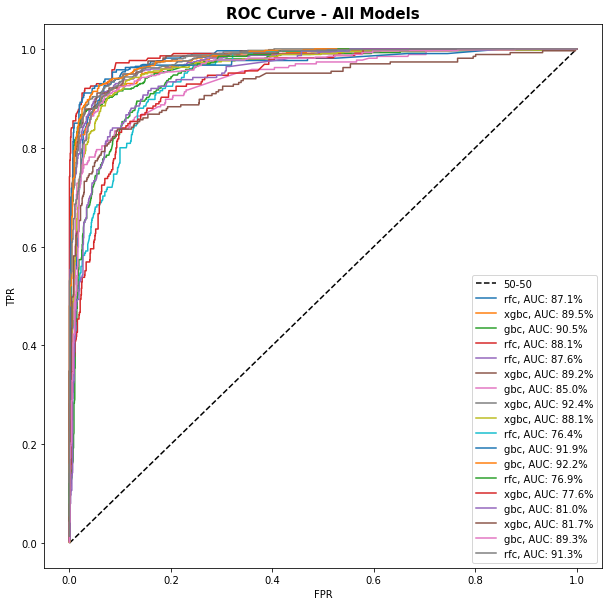

In [55]:
# Plot the ROC curve from the last K-Fold split
fig, ax = plt.subplots(figsize=(10, 10))

# Plot 50-50 Line
ax.plot([0,1],[0,1], ls='--', color='k', label='50-50')

# Plot Classifier ROC Curves
for key, value in roc.items():
    model_name, cat = key
    label = '{}, AUC: {}%'.format(model_name, round(100*value[1],1))
    ax.plot(roc[key][0][0], roc[key][0][1], label=label)
    
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC Curve - All Models',fontweight='bold',fontsize=15)
ax.legend(loc='best')
plt.savefig('../charts/toxic_roc_12.png')

In [ ]:
# # from sklearn.preprocessing import MultiLabelBinarizer
# # Define models to test
# model_list = [['RandomForest', RandomForestClassifier(max_features='auto',n_estimators=1000)], 
#                 ['GradientBoost', GradientBoostingClassifier(n_estimators=500)],
#                 ['XGBoost', XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
#                        gamma=0, learning_rate=0.05, max_delta_step=0, max_depth=6,
#                        min_child_weight=11, missing=-999, n_estimators=500, nthread=4,
#                        objective='reg:linear', reg_alpha=0, reg_lambda=1,
#                        scale_pos_weight=1, seed=0, silent=1, subsample=0.8)]] 

# # Calculate metrics for each model
# roc = {}
# results_dict = {}
# for model in model_list:
    
#     df_A = shuffle(df)[-1000:]
#     X = df_A['comment_text_s']
#     y = pd.cut(df_A.rating, bins=7, labels=list(range(7)))
# #     mlb = MultiLabelBinarizer()
# #     y = mlb.fit_transform(y)
    
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42, stratify=y)
    
#     model_name = model[0]
#     model = model[1]
#     pipe = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),
#                      ('to_dense', DenseTransformer()), ('pipe', model)])

#     accuracy = []
#     precision_1 = []
#     precision_0 = []
#     recall_1 = []
#     recall_0 = []
#     f1_1 = []
#     f1_0 = []
# #     auc = []
        
#     # Perform K-Fold CV and calculate metrics for each fold
#     kf = KFold(5, random_state=42, shuffle=True) 
#     for train_idx, test_idx in kf.split(X, y=y):
#         pipe.fit(X_train, y_train)
#         y_pred = pipe.predict(X_test)
#         accuracy.append(accuracy_score(y_test, y_pred))
#         precision_1.append(precision_score(y_test, y_pred ,pos_label=1, average=None))
#         precision_0.append(precision_score(y_test, y_pred ,pos_label=0, average=None))
#         recall_1.append(recall_score(y_test, y_pred, pos_label=1, average=None))
#         recall_0.append(recall_score(y_test, y_pred, pos_label=0, average=None))
#         f1_1.append(f1_score(y_test, y_pred, pos_label=1, average=None))
#         f1_0.append(f1_score(y_test, y_pred, pos_label=0, average=None))
# #         auc.append(roc_auc_score(y_test, y_pred, average='macro'))
        
#     # Calculate mean metric across K-folds
#     mean_accuracy = np.mean(accuracy)
#     mean_precision_1 = np.mean(precision_1)
#     mean_precision_0 = np.mean(precision_0)
#     mean_recall_1 = np.mean(recall_1)
#     mean_recall_0 = np.mean(recall_0)
#     mean_f1_1 = np.mean(f1_1)
#     mean_f1_0 = np.mean(f1_0)
# #     mean_auc = np.mean(auc)
    
#     # Capture TPR and FPR from last fold for plotting
#     y_score = pipe.predict_proba(X_test)[:,1]
# #     roc[model_name] = roc_curve(y_test, y_score), mean_auc
#     results_dict[model_name] = {"accuracy": mean_accuracy, "precision_s": mean_precision_1, 
#                                 "precision_f": mean_precision_0, "recall_s": mean_recall_1, 
#                                 "recall_f": mean_recall_0, "f1_s": mean_f1_1, "f1_f": mean_f1_0} # "auc": mean_auc
    
#     # Print formatted results
#     print(model)
#     print('\t==============================')
#     print('\tAccuracy:', mean_accuracy)
#     print('\tAUC:', mean_auc)
#     print('\n')
#     print(confusion_matrix(y_test,y_pred))
#     print(classification_report(y_test,y_pred)) 

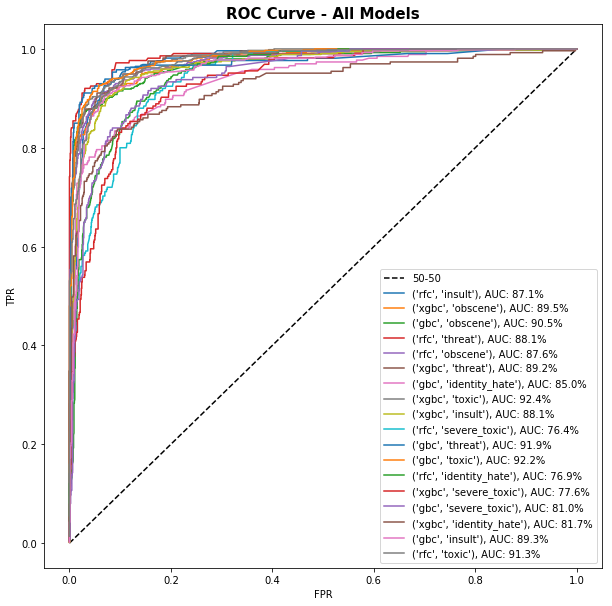

In [56]:
# Plot the ROC curve from the last K-Fold split
fig, ax = plt.subplots(figsize=(10, 10))

# Plot 50-50 Line
ax.plot([0,1],[0,1], ls='--', color='k', label='50-50')

# Plot Classifier ROC Curves
for key, value in roc.items():
    label = '{}, AUC: {}%'.format(key, round(100*value[1],1))
    ax.plot(roc[key][0][0], roc[key][0][1], label=label)
    
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC Curve - All Models',fontweight='bold',fontsize=15)
ax.legend(loc='best')
plt.savefig('../charts/toxic_roc_1.png')

In [57]:
rd = pd.DataFrame(results_dict).T
rd = rd.apply(lambda x: round(100*x,1).astype(str) + "%")
rd = rd.sort_values(['auc'],ascending=[False])
rd

accuracy    auc   f1_f   f1_s precision_f precision_s  \
xgbc toxic            93.0%  92.4%  94.0%  91.6%       91.1%       95.8%   
gbc  toxic            92.9%  92.2%  93.9%  91.3%       90.6%       96.4%   
     threat           96.7%  91.9%  98.1%  88.0%       97.6%       91.2%   
rfc  toxic            91.8%  91.3%  92.9%  90.2%       90.8%       93.1%   
gbc  obscene          92.8%  90.5%  94.6%  89.2%       90.9%       97.1%   
xgbc obscene          91.9%  89.5%  94.0%  87.8%       90.0%       96.5%   
gbc  insult           91.5%  89.3%  93.6%  87.3%       90.4%       93.7%   
xgbc threat           95.9%  89.2%  97.7%  84.8%       96.7%       90.4%   
     insult           90.5%  88.1%  92.9%  85.7%       89.3%       93.2%   
rfc  threat           96.5%  88.1%  98.0%  86.2%       96.2%       99.0%   
     obscene          90.6%  87.6%  93.1%  85.5%       88.2%       96.7%   
     insult           90.1%  87.1%  92.6%  84.7%       88.1%       94.8%   
gbc  identity_hate    93.7%  85.0%  96.2%  80.0%       94.2%       90.4%   
xgbc identity_hate    92.1%  81.7%  95.3%  74.7%       93.0%       86.6%   
gbc  severe_toxic     92.1%  81.0%  95.4%  71.3%       94.0%       78.5%   
xgbc severe_toxic     90.3%  77.6%  94.4%  64.7%       93.1%       70.9%   
rfc  identity_hate    90.6%  76.9%  94.5%  67.7%       91.2%       86.6%   
     severe_toxic     91.3%  76.4%  95.1%  65.6%       92.5%       81.2%   

                   recall_f recall_s  
xgbc toxic            97.1%    87.7%  
gbc  toxic            97.5%    86.8%  
     threat           98.6%    85.1%  
rfc  toxic            95.0%    87.5%  
gbc  obscene          98.6%    82.5%  
xgbc obscene          98.3%    80.6%  
gbc  insult           96.9%    81.6%  
xgbc threat           98.6%    79.8%  
     insult           96.8%    79.4%  
rfc  threat           99.9%    76.3%  
     obscene          98.5%    76.7%  
     insult           97.6%    76.5%  
gbc  identity_hate    98.4%    71.7%  
xgbc identity_hate    97.8%    65.7%  
gbc  severe_toxic     96.8%    65.2%  
xgbc severe_toxic     95.7%    59.6%  
rfc  identity_hate    98.2%    55.6%  
     severe_toxic     97.8%    55.0%